((1000, 5), (1000, 5))

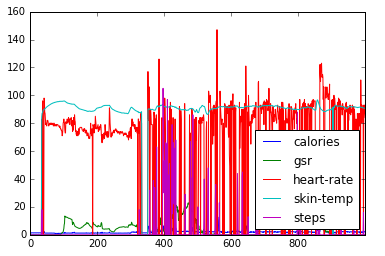

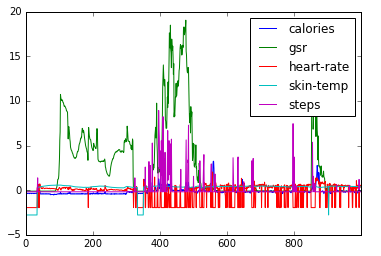

In [26]:
# Data: time-serie data from smartwatch or smartwatch data
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data reading
# The smartwatch historical/time-seris data to visualize
data_path_1xn = 'data/smartwatch_data/experimental_data_analysis/Basis_Watch_Data.csv'
watch_txn = pd.read_csv(data_path_1xn)

# Data: cleaning
# Getting rid of NaN
watch_txn = watch_txn.fillna(value=0.0)

# # Plotting the smartwatch data before scaling/batch normalization
watch_txn[:1000].plot() #x='dteday', y='cnt'

# Data: Preprocessing 
# Batch normalization
features_1x5 = ['calories', 'gsr', 'heart-rate', 'skin-temp', 'steps']
scaled_features_5x2 = {}
for each_name in features_1x5:
    mean_1x1_val, std_1x1_val = watch_txn[each_name].mean(), watch_txn[each_name].std() # std: standard dev. = square-root of MSE/Variance
    scaled_features_5x2[each_name] = [mean_1x1_val, std_1x1_val]
    watch_txn.loc[:, each_name] = (watch_txn[each_name] - mean_1x1_val)/std_1x1_val

# Drop date from the dataset
watch_txn = watch_txn.drop(labels='date', axis=1)

# ploting the data after scaling or batch normalization
watch_txn[:1000].plot()

# Sequence learning - seq2seq learning - Unsupervised Learning
# Training
X_train = np.array(watch_txn[:-2000])
Y_train = np.array(watch_txn[1:-2000+1])
X_train.shape, Y_train.shape

# Validation
X_valid = np.array(watch_txn[-2000:-1000])
Y_valid = np.array(watch_txn[-2000+1:-1000+1])
X_valid.shape, Y_valid.shape

# Testing
X_test = np.array(watch_txn[-1000:])
Y_test = np.array(watch_txn[-1000+1:])
last_row = np.array([np.zeros_like(Y_test[0])])
Y_test = np.row_stack((Y_test, last_row))
X_test.shape, Y_test.shape

In [27]:
# Model
import impl.loss as loss_fun
import impl.layer as l
import impl.utils as util
import impl.NN as nn

class RNN(nn.NN):

    def __init__(self, D, H, L):
        self.D = D
        self.H = H
        self.L = L
        self.losses = {'train':[], 'valid':[], 'test':[]}
#         self.predictions = []
        super().__init__(D, D, H, None, None, loss='cross_ent', nonlin='relu')

    def _init_model(self, D, C, H):
        m = dict(
            Wxh=np.random.randn(D, H) / np.sqrt(D / 2.),
            Whh=np.random.randn(H, H) / np.sqrt(H / 2.),
            Why=np.random.randn(H, D) / np.sqrt(C / 2.),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
            )
        self.model = []
        for l in range(self.L):
            self.model.append(m)
            
    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wxh, Whh, Why = m['Wxh'], m['Whh'], m['Why']
        bh, by = m['bh'], m['by']

        hprev = h.copy()

        h, h_cache = l.tanh_forward(X @ Wxh + hprev @ Whh + bh)
        y, y_cache = l.fc_forward(h, Why, by)

        cache = X, Whh, h, hprev, y, h_cache, y_cache, Wxh

        return y, h, cache

    def backward(self, dy, dh, cache):
        X, Whh, h, hprev, y, h_cache, y_cache, Wxh = cache

        dh_next = dh.copy()
        
        # Hidden to output gradient
        dh, dWhy, dby = l.fc_backward(dy, y_cache)
        dh += dh_next
        dby = dby.reshape((1, -1))

        # tanh
        dh = l.tanh_backward(dh, h_cache)

        # Hidden gradient
        dbh = dh
        dWhh = hprev.T @ dh
        dWxh = X.T @ dh
        
        dX = dh @ Wxh.T
        dh = dh @ Whh.T

        grad = dict(Wxh=dWxh, Whh=dWhh, Why=dWhy, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for l in range(self.L):
            h.append(h_init.copy())
            caches.append([])
            
        for X in X_train:
            #             X_one_hot = np.zeros(self.D)
            #             X_one_hot[X] = 1.
            #             y = X_one_hot.reshape(1, -1)
            y = X.reshape(1, -1)
            for l in range(self.L):
                y, h[l], cache = self.forward(y, h[l], self.model[l])
                caches[l].append(cache)
                
            ys.append(y)
            
        return ys, caches

    def l2_regression_NEW(self, y_pred, y_train):
        m = y_pred.shape[0]

        # (F(x)-y)^2: convex as X^2
        data_loss = 0.5 * np.sum((y_pred - y_train)**2) / m
    
        return data_loss

    def dl2_regression_NEW(self, y_pred, y_train):
        m = y_pred.shape[0]

        # (F(x)-y)^2: convex as X^2
        dy = 0.5 * (y_pred - y_train) / m

        return dy

    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.l2_regression_NEW(y_pred, y)/ y_train.shape[0]
            dy = self.dl2_regression_NEW(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for l in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
            
        for t in reversed(range(len(dys))):
            dX = dys[t]
            for l in reversed(range(self.L)):
                dX, dh[l], grad[l] = self.backward(dX, dh[l], caches[l][t])
                for k in grad[0].keys():
                    grads[l][k] += grad[l][k]
                
        return dX, grads
    
    def test(self, X_seed, h, size):
        h_init = h.copy()
        h = []
        for l in range(self.L):
            h.append(h_init.copy())

        ys = []
        y = X_seed.reshape(1, -1)

        for t in range(size): # range(start=0, stop=size, step=1)
            for l in range(self.L):
                y, h[l], cache = self.forward(y, h[l], self.model[l])
            ys.append(y)
            
        return ys

In [28]:
import impl.constant as c
import copy
from sklearn.utils import shuffle as skshuffle

def get_minibatch(X, y, minibatch_size, shuffle=True):
    minibatches = []

    if shuffle:
        X, y = skshuffle(X, y)

    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]

        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, Y_train, X_valid, Y_valid, X_test, alpha, mb_size, n_iter, print_after):
    minibatches = get_minibatch(X_train, Y_train, mb_size, shuffle=False)

    # Remember: only one minibatch in size of timestep is needed.
    minibatches_valid = get_minibatch(X_valid, Y_valid, mb_size, shuffle=False)
#     minibatches_test = get_minibatch(X_test, Y_test, mb_size, shuffle=False)

    idx, idx_v = 0, 0
    state = nn.initial_state()
    
    M, R = [], []
    for l in range(nn.L):
        M.append({k: np.zeros_like(v) for k, v in nn.model[0].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[0].items()})
        
    beta1 = .9
    beta2 = .999

    for iter in range(1, n_iter + 1):

        # The training to learn the gradients/derivatives
        if idx >= len(minibatches):
            idx = 0
            state = nn.initial_state()

        X_mini, y_mini = minibatches[idx]
        ys, caches = nn.train_forward(X_mini, state)
        loss, dys = nn.loss_function(y_mini, ys)
        _, grads = nn.train_backward(dys, caches)
        nn.losses['train'].append(loss)
        idx += 1

        # The validation step: to validate the training and make sure it is not being overfit or maybe underfit
        if idx_v>=len(minibatches_valid):
            idx_v = 0
            state = nn.initial_state()
        X_mini_valid, y_mini_valid = minibatches_valid[0]
        ys_valid, _ = nn.train_forward(X_mini_valid, state)
        loss_valid, _ = nn.loss_function(y_mini_valid, ys_valid)
        nn.losses['valid'].append(loss_valid)
        idx_v += 1
        
        #        # Testing can be performed after the training and validation process
        #         X_mini_test, _ = minibatches_test[0]
        #         ys_test = nn.test(X_mini_test[0], state, size=mb_size)
        #         nn.predictions.append(ys_test)


        # Print loss of training and validation
        if iter % print_after == 0:
            print('Iter-{} training loss: {:.4f}'.format(iter, loss))
            print('Iter-{} validation loss: {:.4f}'.format(iter, loss_valid))

        for l in range(nn.L):
            for k in grads[0].keys(): #key, value: items
                M[l][k] = util.exp_running_avg(M[l][k], grads[l][k], beta1)
                R[l][k] = util.exp_running_avg(R[l][k], grads[l][k]**2, beta2)

                m_k_hat = M[l][k] / (1. - beta1**(iter))
                r_k_hat = R[l][k] / (1. - beta2**(iter))

                nn.model[l][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + c.eps)
    
    return nn

In [30]:
# hyper parameters
n_iter = 10000 # epochs
alpha = 1e-3 # learning_rate
print_after = 1000 # print lossof train, valid, or test
time_step = 100 # width of the model or minibatch size
num_hidden_units = 64 # width of the hidden layers or number of hidden units in hidden layer
num_hidden_layers = 1 # depth or number of hidden layer
num_input_units = X_train.shape[1] # number of input features/dimensions

In [31]:
net = RNN(D=num_input_units, H=num_hidden_units, L=num_hidden_layers)

adam_rnn(nn=net, X_train=X_train, Y_train=Y_train, X_valid=X_valid, Y_valid=Y_valid, X_test=X_test, 
         alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

Iter-10 training loss: 16.4069
Iter-10 validation loss: 29.1395
Iter-20 training loss: 20.2299
Iter-20 validation loss: 20.5953
Iter-30 training loss: 1.9721
Iter-30 validation loss: 15.4247
Iter-40 training loss: 1.9596
Iter-40 validation loss: 11.9476
Iter-50 training loss: 7.9032
Iter-50 validation loss: 9.2531
Iter-60 training loss: 4.4573
Iter-60 validation loss: 7.7241
Iter-70 training loss: 12.9924
Iter-70 validation loss: 7.1566
Iter-80 training loss: 9.7920
Iter-80 validation loss: 6.3836
Iter-90 training loss: 3.3923
Iter-90 validation loss: 5.6998
Iter-100 training loss: 2.0903
Iter-100 validation loss: 5.3290
Iter-110 training loss: 7.1294
Iter-110 validation loss: 5.0709
Iter-120 training loss: 5.5563
Iter-120 validation loss: 4.6157
Iter-130 training loss: 11.6146
Iter-130 validation loss: 4.2477
Iter-140 training loss: 0.5412
Iter-140 validation loss: 4.1475
Iter-150 training loss: 1.8300
Iter-150 validation loss: 4.1063
Iter-160 training loss: 3.3786
Iter-160 validation

Iter-1300 training loss: 0.5041
Iter-1300 validation loss: 2.9148
Iter-1310 training loss: 0.1538
Iter-1310 validation loss: 2.9355
Iter-1320 training loss: 0.5787
Iter-1320 validation loss: 2.9794
Iter-1330 training loss: 0.0813
Iter-1330 validation loss: 2.9391
Iter-1340 training loss: 0.5541
Iter-1340 validation loss: 2.8419
Iter-1350 training loss: 1.4783
Iter-1350 validation loss: 2.8217
Iter-1360 training loss: 0.6802
Iter-1360 validation loss: 2.8648
Iter-1370 training loss: 0.5961
Iter-1370 validation loss: 2.8742
Iter-1380 training loss: 1.4972
Iter-1380 validation loss: 2.8259
Iter-1390 training loss: 3.0237
Iter-1390 validation loss: 3.4174
Iter-1400 training loss: 0.0225
Iter-1400 validation loss: 3.7318
Iter-1410 training loss: 0.7286
Iter-1410 validation loss: 3.9075
Iter-1420 training loss: 1.1749
Iter-1420 validation loss: 3.8988
Iter-1430 training loss: 0.4405
Iter-1430 validation loss: 3.8899
Iter-1440 training loss: 2.4995
Iter-1440 validation loss: 3.8207
Iter-1450 

Iter-2560 training loss: 0.5373
Iter-2560 validation loss: 2.6415
Iter-2570 training loss: 0.3932
Iter-2570 validation loss: 2.6026
Iter-2580 training loss: 0.0320
Iter-2580 validation loss: 2.6520
Iter-2590 training loss: 0.6388
Iter-2590 validation loss: 2.6675
Iter-2600 training loss: 0.6492
Iter-2600 validation loss: 2.6202
Iter-2610 training loss: 0.1745
Iter-2610 validation loss: 2.5829
Iter-2620 training loss: 0.5752
Iter-2620 validation loss: 2.5142
Iter-2630 training loss: 0.8198
Iter-2630 validation loss: 2.5076
Iter-2640 training loss: 0.0790
Iter-2640 validation loss: 2.5123
Iter-2650 training loss: 0.5440
Iter-2650 validation loss: 2.5331
Iter-2660 training loss: 0.9140
Iter-2660 validation loss: 2.5391
Iter-2670 training loss: 4.1992
Iter-2670 validation loss: 2.5453
Iter-2680 training loss: 0.0527
Iter-2680 validation loss: 2.6089
Iter-2690 training loss: 0.7319
Iter-2690 validation loss: 2.6506
Iter-2700 training loss: 0.0476
Iter-2700 validation loss: 2.6540
Iter-2710 

Iter-3820 training loss: 1.1857
Iter-3820 validation loss: 6.3045
Iter-3830 training loss: 2.2170
Iter-3830 validation loss: 5.6254
Iter-3840 training loss: 0.0266
Iter-3840 validation loss: 2.9153
Iter-3850 training loss: 0.8438
Iter-3850 validation loss: 2.2898
Iter-3860 training loss: 1.8615
Iter-3860 validation loss: 2.2074
Iter-3870 training loss: 0.3141
Iter-3870 validation loss: 2.2230
Iter-3880 training loss: 0.3526
Iter-3880 validation loss: 2.2253
Iter-3890 training loss: 1.1109
Iter-3890 validation loss: 2.2548
Iter-3900 training loss: 1.0540
Iter-3900 validation loss: 2.1864
Iter-3910 training loss: 0.0245
Iter-3910 validation loss: 2.1393
Iter-3920 training loss: 0.9232
Iter-3920 validation loss: 2.1301
Iter-3930 training loss: 0.7011
Iter-3930 validation loss: 2.1390
Iter-3940 training loss: 0.0574
Iter-3940 validation loss: 2.0766
Iter-3950 training loss: 0.4176
Iter-3950 validation loss: 2.1773
Iter-3960 training loss: 0.1725
Iter-3960 validation loss: 2.6469
Iter-3970 

Iter-5080 training loss: 0.0208
Iter-5080 validation loss: 1.5776
Iter-5090 training loss: 0.0499
Iter-5090 validation loss: 1.5689
Iter-5100 training loss: 1.3911
Iter-5100 validation loss: 1.5574
Iter-5110 training loss: 0.7725
Iter-5110 validation loss: 1.5671
Iter-5120 training loss: 0.0169
Iter-5120 validation loss: 1.6480
Iter-5130 training loss: 1.3828
Iter-5130 validation loss: 1.6859
Iter-5140 training loss: 0.0121
Iter-5140 validation loss: 1.4709
Iter-5150 training loss: 0.0069
Iter-5150 validation loss: 1.5093
Iter-5160 training loss: 0.4557
Iter-5160 validation loss: 1.5567
Iter-5170 training loss: 0.7247
Iter-5170 validation loss: 1.4186
Iter-5180 training loss: 0.0261
Iter-5180 validation loss: 1.4866
Iter-5190 training loss: 0.1276
Iter-5190 validation loss: 1.4909
Iter-5200 training loss: 2.5542
Iter-5200 validation loss: 1.5673
Iter-5210 training loss: 0.1652
Iter-5210 validation loss: 1.6747
Iter-5220 training loss: 0.0459
Iter-5220 validation loss: 1.5333
Iter-5230 

Iter-6340 training loss: 1.6684
Iter-6340 validation loss: 1.3751
Iter-6350 training loss: 1.9985
Iter-6350 validation loss: 1.4683
Iter-6360 training loss: 0.0216
Iter-6360 validation loss: 1.3968
Iter-6370 training loss: 1.3726
Iter-6370 validation loss: 1.3445
Iter-6380 training loss: 1.3030
Iter-6380 validation loss: 1.3526
Iter-6390 training loss: 0.0143
Iter-6390 validation loss: 1.3099
Iter-6400 training loss: 0.3021
Iter-6400 validation loss: 1.2907
Iter-6410 training loss: 1.7934
Iter-6410 validation loss: 1.3603
Iter-6420 training loss: 2.5767
Iter-6420 validation loss: 1.3570
Iter-6430 training loss: 0.0666
Iter-6430 validation loss: 1.3161
Iter-6440 training loss: 2.4054
Iter-6440 validation loss: 1.3234
Iter-6450 training loss: 4.1909
Iter-6450 validation loss: 1.4622
Iter-6460 training loss: 0.1234
Iter-6460 validation loss: 2.0430
Iter-6470 training loss: 0.1447
Iter-6470 validation loss: 2.4100
Iter-6480 training loss: 0.5719
Iter-6480 validation loss: 2.1653
Iter-6490 

Iter-7600 training loss: 0.5809
Iter-7600 validation loss: 2.0605
Iter-7610 training loss: 0.0076
Iter-7610 validation loss: 2.0945
Iter-7620 training loss: 0.0036
Iter-7620 validation loss: 2.2367
Iter-7630 training loss: 0.7173
Iter-7630 validation loss: 2.4010
Iter-7640 training loss: 0.0542
Iter-7640 validation loss: 2.1087
Iter-7650 training loss: 0.2678
Iter-7650 validation loss: 2.1471
Iter-7660 training loss: 2.7875
Iter-7660 validation loss: 2.2158
Iter-7670 training loss: 0.0985
Iter-7670 validation loss: 2.1611
Iter-7680 training loss: 0.0055
Iter-7680 validation loss: 1.9218
Iter-7690 training loss: 0.3364
Iter-7690 validation loss: 2.0227
Iter-7700 training loss: 0.2015
Iter-7700 validation loss: 1.9240
Iter-7710 training loss: 0.0459
Iter-7710 validation loss: 2.1203
Iter-7720 training loss: 0.2678
Iter-7720 validation loss: 1.6178
Iter-7730 training loss: 2.1257
Iter-7730 validation loss: 1.7722
Iter-7740 training loss: 0.0970
Iter-7740 validation loss: 1.3874
Iter-7750 

Iter-8860 training loss: 0.1353
Iter-8860 validation loss: 1.1263
Iter-8870 training loss: 0.5338
Iter-8870 validation loss: 1.0509
Iter-8880 training loss: 0.0072
Iter-8880 validation loss: 0.8988
Iter-8890 training loss: 0.1839
Iter-8890 validation loss: 0.8510
Iter-8900 training loss: 0.5747
Iter-8900 validation loss: 0.8526
Iter-8910 training loss: 0.1400
Iter-8910 validation loss: 0.8666
Iter-8920 training loss: 0.0342
Iter-8920 validation loss: 0.9785
Iter-8930 training loss: 0.5953
Iter-8930 validation loss: 0.9302
Iter-8940 training loss: 0.0715
Iter-8940 validation loss: 0.8861
Iter-8950 training loss: 1.7136
Iter-8950 validation loss: 1.1313
Iter-8960 training loss: 0.2368
Iter-8960 validation loss: 0.8505
Iter-8970 training loss: 1.9019
Iter-8970 validation loss: 0.8440
Iter-8980 training loss: 0.0177
Iter-8980 validation loss: 1.0480
Iter-8990 training loss: 0.8699
Iter-8990 validation loss: 1.1610
Iter-9000 training loss: 0.8313
Iter-9000 validation loss: 0.9449
Iter-9010 

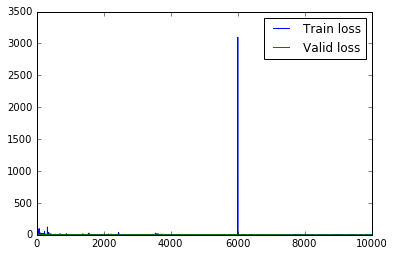

In [34]:
# Display the learning curve and losses for training, validation, and testing
% matplotlib inline
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['valid'], label='Valid loss')
plt.legend()

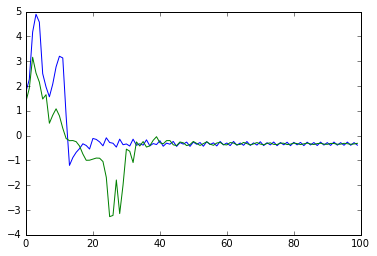

In [40]:
mb = get_minibatch(X=X_test, y=Y_test, minibatch_size=time_step, shuffle=False)
# len(mb)
X, Y = mb[len(mb)//100]
X.shape, Y.shape
state = net.initial_state()
X_test = net.test(X_seed=X[0], h=state, size=time_step)
# len(X_test)
X_test = np.array(X_test)
X = np.array(X)
X_test.shape, X.shape
plt.plot(X_test[:, :, 0], label='X_test')
plt.plot(X[:, :, 0], label='X')